## Install dependencies

In [22]:
!pip install optuna joblib xgboost ta

In [23]:
from datetime import datetime, timedelta, timezone
import pandas as pd
import numpy as np
import requests
import os
import logging
import sys
import optuna
import joblib
import xgboost as xgb

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
from ta import add_all_ta_features

In [25]:
import matplotlib.pyplot as plt
import matplotlib

## Variables

In [26]:
current_storage = os.path.join("d:", "data")
vn30f_storage = os.path.join(current_storage, 'vn30f')

In [27]:
start_time = 0
now_time = 9999999999
symbol = 'VN30F1M'
rolling_window = 1 # Số phút muốn dự đoán tiếp theo

In [28]:
# Add stream handler of stdout to show the messages
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "btc1-study"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

## Formulas

In [29]:
def choose_position(roi, trade_threshold = 0.0005):
    pos =0
    # Predict position base on change in future
    if roi > trade_threshold:
        pos = 1
    elif roi < -trade_threshold:
        pos = -1
    else:
        pos = 0

    return pos

In [30]:
def backtest_position_ps(position, price, percentage, periods):
    # Shift positions to align with future price changes and handle NaN by filling with 0
    pos = pd.Series(position, index=pd.Series(price).index).shift(1).fillna(0)
    pos = pd.Series(pos).rolling(periods).sum() #pos for 10 hour predict

    price_array = pd.Series(price).shift(1).fillna(0)

    pos_diff = pos.diff()
    fee = pos_diff*price_array*0.05*0.01

    # Calculate price changes over the given periods
    ch = pd.Series(price) - price_array

    # Calculate total PnL
    total_pnl = pos*ch - fee
    return total_pnl

In [31]:
def calculate_sharpe_ratio(pnl):
    pnl = np.diff(pnl)
    std = np.std(pnl) if np.std(pnl) != 0 else 0.001
    sharpe = np.mean(pnl)/std*np.sqrt(252)
    return sharpe

In [32]:
def sharpe_for_vn30f(y_pred, y_price, trade_threshold, fee_perc, periods):

    # Predict position base on change in future
    pos = [choose_position(roi, trade_threshold) for roi in y_pred]
    pos = np.array(pos)

    # Calculate PNL
    pnl = backtest_position_ps(pos, y_price, fee_perc, periods)
    pnl = np.cumsum(pnl)

    # Standardalize PNL to date
    daily_pnl = [pnl.iloc[i] for i in range(0, len(pnl), 24)]
    daily_pnl = pd.Series(daily_pnl).fillna(0)

    # Calculate Sharpe
    sharpe = calculate_sharpe_ratio(daily_pnl)

    return pos, pnl, daily_pnl, sharpe

In [33]:
def calculate_hitrate(pos_predict, pos_true):
    if len(pos_predict) != len(pos_true):
        raise ValueError("Độ dài của hai mảng không khớp")

    # Tính số lượng dự đoán đúng (các phần tử tương ứng giống nhau)
    correct_predictions = np.sum(pos_predict == pos_true)

    # Tính tỷ lệ hit rate
    hit_rate_value = correct_predictions / len(pos_predict)

    return hit_rate_value

# Function for data

In [34]:
def scale_data(data):
    scaler = StandardScaler()
    scaler.fit(data)
    data=pd.DataFrame(scaler.transform(data), index=data.index, columns=data.columns)

    return data

In [35]:
def split_data(data):
    """
    Hàm này chia dữ liệu thành 2 phần: tập huấn luyện và tập hold out.

    Args:
    data (pandas.DataFrame): DataFrame chứa dữ liệu cần chia.

    Returns:
    pandas.DataFrame: DataFrame chứa dữ liệu tập huấn luyện.
    pandas.DataFrame: DataFrame chứa dữ liệu tập giữ lại.
    """
    # Chia dữ liệu thành 3 phần
    new_part = np.array_split(data, 3)

    # Access each part individually
    hold_out = new_part[2]
    train_data = pd.concat([new_part[0], new_part[1]], axis=0)

    return train_data, hold_out

def split_optuna_data(data):
    """
    Hàm này chia dữ liệu thành các tập train và test để sử dụng trong quá trình tối ưu hóa bằng Optuna.

    Args:
    data (pandas.DataFrame): DataFrame chứa dữ liệu cần chia.

    Returns:
    pandas.DataFrame: DataFrame chứa dữ liệu train (đã được chuẩn hóa).
    pandas.DataFrame: DataFrame chứa dữ liệu test (đã được chuẩn hóa).
    pandas.Series: Series chứa nhãn tương ứng với dữ liệu train.
    pandas.Series: Series chứa nhãn tương ứng với dữ liệu test.
    """
    # Chia dữ liệu thành tập train và tập hold out
    train_data, _ = split_data(data)

    # Loại bỏ các cột không cần thiết
    if 'Open' in train_data.columns:
        optuna_data = train_data.drop(['Open','High','Low','Close','Volume', 'Return', 'Date', 'time'], axis=1)
    else:
        optuna_data = train_data.drop(['Close', 'Return', 'Date', 'time'], axis=1)

    # Chuẩn hóa dữ liệu
    optuna_data = scale_data(optuna_data)

    # Chia dữ liệu thành tập train và tập test
    X_train, X_valid, y_train, y_valid = train_test_split(optuna_data, train_data['Return'], test_size=0.5, shuffle=False)

    return X_train, X_valid, y_train, y_valid, train_data

## Get data

In [36]:
def get_vn30f(start_time, now_time, symbol):
    def vn30f():
            return requests.get(f"https://services.entrade.com.vn/chart-api/v2/ohlcs/index?from={1677628800}&to={1690848000}&symbol=VN30&resolution=1").json()
    vn30fm = pd.DataFrame(vn30f()).iloc[:,:6]
    vn30fm['t'] = vn30fm['t'].astype(int).apply(lambda x: datetime.utcfromtimestamp(x) + timedelta(hours = 7))
    vn30fm.columns = ['Date','Open','High','Low','Close','Volume']
    ohlc_dict = {
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum',}
    vn30fm = pd.DataFrame(vn30f()).iloc[:,:6]
    vn30fm['t'] = vn30fm['t'].astype(int).apply(lambda x: datetime.utcfromtimestamp(x) + timedelta(hours = 7))
    vn30fm.columns = ['Date','Open','High','Low','Close','Volume']
    dt_object = datetime.utcfromtimestamp(1677628800) + timedelta(hours = 7)
    now_object = datetime.utcfromtimestamp(1690848000) + timedelta(hours = 7)

    print(f'===> Data {symbol} from {dt_object} to {now_object} has been appended ')

    return vn30fm

# df2 = get_vn30f(start_time, now_time, symbol)

In [37]:
df = get_vn30f(start_time, now_time, symbol)

===> Data VN30F1M from 2023-03-01 07:00:00 to 2023-08-01 07:00:00 has been appended 


In [38]:
data = df.copy()

In [39]:
data_april_2023 = data[
    (data['Date'] >= '2023-04-01') & (data['Date'] <= '2023-07-30')
]
data_april_2023

,Date,Open,High,Low,Close,Volume
5213,2023-04-03 09:15:00,1085.15,1085.76,1084.22,1085.37,6387700
5214,2023-04-03 09:16:00,1085.22,1086.72,1085.22,1086.72,2035900
5215,2023-04-03 09:17:00,1086.73,1086.92,1086.23,1086.79,1684400
5216,2023-04-03 09:18:00,1086.59,1086.59,1085.59,1085.59,1971500
5217,2023-04-03 09:19:00,1085.97,1086.23,1085.35,1085.96,1767700
...,...,...,...,...,...,...
23774,2023-07-28 14:27:00,1207.73,1208.06,1206.98,1207.48,1402592
23775,2023-07-28 14:28:00,1208.12,1208.76,1207.86,1208.69,2258000
23776,2023-07-28 14:29:00,1208.72,1208.77,1208.13,1208.23,1339904
23777,2023-07-28 14:30:00,1208.28,1208.28,1208.28,1208.28,31408


## Preprocess

In [40]:
from scipy.stats.mstats import winsorize
# Áp dụng Winsorization
data['Close'] = winsorize(data['Close'], limits=[0.05, 0.05])

In [41]:
def process_data(data):
    data.set_index('Date', inplace =True)
    data.columns = ['Open','High','Low','Close','Volume']

    data['Date'] = [str(i)[:10] for i in data.index]
    data['time'] = [str(i)[11:] for i in data.index]

    data = data[~data.index.duplicated(keep='first')] # Handling duplicate
    data_model = data.pivot(index = 'Date', columns = 'time', values = ['Open','High','Low','Close','Volume']).ffill(axis = 1).stack().reset_index() # Handling missing values
    # data_model.columns = ['Date','time','Close']

    return data_model

In [42]:
data = process_data(data)

In [43]:
data

,Date,time,Open,High,Low,Close,Volume
0,2023-03-01,09:15:00,1008.16,1009.58,1008.16,1029.36,1007200.0
1,2023-03-01,09:16:00,1010.71,1010.71,1008.34,1029.36,592900.0
2,2023-03-01,09:17:00,1008.60,1008.60,1004.45,1029.36,884700.0
3,2023-03-01,09:18:00,1004.51,1005.49,1004.49,1029.36,265500.0
4,2023-03-01,09:19:00,1003.14,1004.11,1002.25,1029.36,861000.0
...,...,...,...,...,...,...,...
24057,2023-07-31,14:27:00,1227.80,1229.02,1227.60,1189.23,3089600.0
24058,2023-07-31,14:28:00,1228.21,1229.54,1228.21,1189.23,3717600.0
24059,2023-07-31,14:29:00,1229.74,1230.17,1229.69,1189.23,3368800.0
24060,2023-07-31,14:30:00,1229.70,1229.70,1229.70,1189.23,88416.0


## Create features

In [44]:
def generate_features(df, shift=1):
    """
    Hàm này tạo ra các features mới từ dữ liệu cổ phiếu.

    Args:
    df (pandas.DataFrame): DataFrame chứa dữ liệu cần tạo features, có các cột 'open', 'high', 'low', 'close' và 'volume'.

    Returns:
    pandas.DataFrame: DataFrame đã được mở rộng với các features mới.
    """

    # Thêm tất cả các đặc trưng kỹ thuật từ thư viện TA-Lib
    df_shift = df.shift(shift)
    df_shift = add_all_ta_features(df_shift, open="Open", high="High", low="Low", close="Close", volume="Volume")

    # Drop the original OHLCV columns from the shifted DataFrame
    df_shift = df_shift.drop(columns=['Date','time', 'Open','High','Low','Close','Volume'])

    df = pd.concat([df, df_shift], axis=1)

    ### Ví dụ các features thêm tay
    # Tính phần trăm thay đổi của giá đóng cửa trong 5 phút
    df['Trend_5min'] = df['Close'].shift(shift).pct_change(periods=5)

    # Tính độ lệch chuẩn của giá đóng cửa trong 30 phút
    df['Std_Rolling_30min'] = df['Close'].shift(shift).rolling(window=30, min_periods=1).std()

    # Tính độ lệch của giá đóng cửa so với trung bình động 30 phút
    ma_30min = df['Close'].shift(shift).rolling(window=30, min_periods=1).mean()
    df['Close_Minus_MA_30min'] = df['Close'].shift(shift) - ma_30min

    # Tính trung bình động 10 phút của giá đóng cửa
    df['SMA_10'] = df['Close'].shift(shift).rolling(window=10, min_periods=1).mean()

    # Identify numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    # Replace infinite values with NaN in numeric columns
    df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)

    # Điền các giá trị NaN với 0
    df = df.fillna(0)

    return df

In [45]:
data  = generate_features(data)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)


Thêm các feature khác, ví dụ giá vàng (xem xét phù hợp với thời gian trong data)

# Add Predict Features

In [46]:
data['Return'] = (data['Close'].shift(-rolling_window) - data['Close'])/data['Close']
data = data.fillna(0)
data = data.drop(index=0)
data

,Date,time,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,...,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,Trend_5min,Std_Rolling_30min,Close_Minus_MA_30min,SMA_10,Return
1,2023-03-01,09:16:00,1010.71,1010.71,1008.34,1029.36,592900.0,2.906694e+07,1.007200e+06,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1029.36,0.0
2,2023-03-01,09:17:00,1008.60,1008.60,1004.45,1029.36,884700.0,3.899114e+07,1.600100e+06,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1029.36,0.0
3,2023-03-01,09:18:00,1004.51,1005.49,1004.49,1029.36,265500.0,4.872710e+07,2.484800e+06,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1029.36,0.0
4,2023-03-01,09:19:00,1003.14,1004.11,1002.25,1029.36,861000.0,6.166757e+07,2.750300e+06,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1029.36,0.0
5,2023-03-01,09:20:00,1002.35,1002.36,1001.62,1029.36,438700.0,8.590518e+07,3.611300e+06,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1029.36,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24057,2023-07-31,14:27:00,1227.80,1229.02,1227.60,1189.23,3089600.0,0.000000e+00,2.611128e+09,-115.370111,...,8.936953,1189.226590,0.0,0.0,0.0,0.0,0.0,0.0,1189.23,0.0
24058,2023-07-31,14:28:00,1228.21,1229.54,1228.21,1189.23,3717600.0,0.000000e+00,2.614217e+09,-109.124943,...,7.935707,1189.226605,0.0,0.0,0.0,0.0,0.0,0.0,1189.23,0.0
24059,2023-07-31,14:29:00,1229.74,1230.17,1229.69,1189.23,3368800.0,0.000000e+00,2.617935e+09,-104.686549,...,8.233947,1189.226619,0.0,0.0,0.0,0.0,0.0,0.0,1189.23,0.0
24060,2023-07-31,14:30:00,1229.70,1229.70,1229.70,1189.23,88416.0,0.000000e+00,2.621304e+09,-108.873006,...,6.927609,1189.226633,0.0,0.0,0.0,0.0,0.0,0.0,1189.23,0.0


# Feature Engineering

In [47]:
def drop_high_corr_columns(df, threshold=0.6):
    ohlcv_columns = {'Date','time', 'Open','High','Low','Close','Volume'}

     # Identify non-OHLCV and non-date/time columns
    non_corr_columns = [col for col in df.columns if col not in ohlcv_columns]

    # Compute the correlation matrix only for non-OHLCV and non-date/time columns
    corr_matrix = df[non_corr_columns].corr().abs()

    # Create a set to keep track of columns to drop
    to_drop = set()

    # Iterate over the upper triangle of the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                # If the correlation is higher than the threshold, mark the column with the higher index to drop
                col_to_drop = corr_matrix.columns[j]
                if col_to_drop not in ohlcv_columns:
                    to_drop.add(col_to_drop)

    # Drop the columns from the DataFrame
    df_dropped = df.drop(columns=to_drop)
    return df_dropped

data = drop_high_corr_columns(data)

In [48]:
def objective(trial, X_train, X_valid, y_train, y_valid, y_price):

    # Select features based on Optuna's suggestions
    selected_features = []
    for col in X_train.columns:
        if trial.suggest_categorical(col, [0, 1]):
            selected_features.append(col)

    for t in trial.study.trials:
        if t.state != optuna.trial.TrialState.COMPLETE:
            continue

    # trade_threshold = trial.suggest_float('trade_threshold', 0.008, 0.08, step=0.0004)
    trade_threshold  = 0.0005

    # Use only the selected features in training
    X_train_selected = X_train[selected_features]
    X_valid_selected = X_valid[selected_features]

    # Train the model
    model = xgb.XGBRegressor()
    model.fit(X_train_selected, y_train)

    y_pred_train = model.predict(X_train_selected)
    y_pred_valid = model.predict(X_valid_selected)

    _, pos_is, _, sharpe_is = sharpe_for_vn30f(y_pred_train, y_price[:len(y_pred_train)], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)
    _, pos_os, _, sharpe_oos = sharpe_for_vn30f(y_pred_valid, y_price[len(y_pred_train):], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)

    print('Trade times in sample:',len(pos_is[pos_is != 0]), 'Trade times out sample:',len(pos_os[pos_os != 0]))

    return sharpe_oos, abs((abs(sharpe_is / sharpe_oos))-1)

X_train, X_valid, y_train, y_valid, train_data = split_optuna_data(data)

In [49]:
"""## Define number of trials (no 2)"""

# Create a study object and optimize the objective function
study = optuna.create_study(directions=['maximize', 'minimize'])
unique_trials = 50

while unique_trials > len(set(str(t.params) for t in study.trials)):
    study.optimize(lambda trial: objective(trial, X_train, X_valid, y_train, y_valid, train_data['Close']), n_trials=1)
    study.trials_dataframe().sort_values('values_0').to_csv('feature_trials.csv')
    joblib.dump(study, 'abmodel.pkl')

trials = study.trials
trials.sort(key=lambda trial: trial.values, reverse=True)
study.trials_dataframe().sort_values('values_0', ascending=False).duplicated().sum()

"""## Checking part for fixing bug"""
df =study.trials_dataframe()

# df.to_csv('save_trials.csv')

[I 2024-06-11 02:59:43,254] A new study created in memory with name: no-name-7b6dc38b-96a4-4e4e-bb3f-b2b511ad6d9c


A new study created in memory with name: no-name-7b6dc38b-96a4-4e4e-bb3f-b2b511ad6d9c
A new study created in memory with name: no-name-7b6dc38b-96a4-4e4e-bb3f-b2b511ad6d9c


[I 2024-06-11 02:59:45,722] Trial 0 finished with values: [-1.0595071355463723, 1.311865890649607] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 1, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 


Trade times in sample: 6926 Trade times out sample: 7617
Trial 0 finished with values: [-1.0595071355463723, 1.311865890649607] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 1, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 
Trial 0 finished with values: [-1.0595071355463723, 1.311865890649607] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'v

[I 2024-06-11 02:59:48,569] Trial 1 finished with values: [1.5837732703992247, 0.3848052244753253] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 0}. 


Trade times in sample: 6924 Trade times out sample: 7308
Trial 1 finished with values: [1.5837732703992247, 0.3848052244753253] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 0}. 
Trial 1 finished with values: [1.5837732703992247, 0.3848052244753253] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 0, 'v

[I 2024-06-11 02:59:49,105] Trial 2 finished with values: [0.25810795722083674, 8.663636481718493] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 0}. 


Trade times in sample: 7756 Trade times out sample: 7314
Trial 2 finished with values: [0.25810795722083674, 8.663636481718493] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 0}. 
Trial 2 finished with values: [0.25810795722083674, 8.663636481718493] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'v

[I 2024-06-11 02:59:49,795] Trial 3 finished with values: [-0.03445924270298814, 66.03515455748261] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kchi': 1, 'volatility_kcli': 0, 'volatility_ui': 1, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 7803 Trade times out sample: 6290
Trial 3 finished with values: [-0.03445924270298814, 66.03515455748261] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kchi': 1, 'volatility_kcli': 0, 'volatility_ui': 1, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 
Trial 3 finished with values: [-0.03445924270298814, 66.03515455748261] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 1, 

[I 2024-06-11 02:59:50,999] Trial 4 finished with values: [-0.6235709995346171, 3.498247614497121] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 1}. 


Trade times in sample: 7116 Trade times out sample: 7927
Trial 4 finished with values: [-0.6235709995346171, 3.498247614497121] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 1}. 
Trial 4 finished with values: [-0.6235709995346171, 3.498247614497121] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 1, 'v

[I 2024-06-11 02:59:53,283] Trial 5 finished with values: [0.3032171406480844, 7.791688998903151] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 1, 'trend_macd': 0, 'trend_mass_index': 1, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 1}. 


Trade times in sample: 7114 Trade times out sample: 6768
Trial 5 finished with values: [0.3032171406480844, 7.791688998903151] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 1, 'trend_macd': 0, 'trend_mass_index': 1, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 1}. 
Trial 5 finished with values: [0.3032171406480844, 7.791688998903151] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'vol

[I 2024-06-11 02:59:54,073] Trial 6 finished with values: [1.5864030858569633, 0.3148585680863709] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 0}. 


Trade times in sample: 6700 Trade times out sample: 7901
Trial 6 finished with values: [1.5864030858569633, 0.3148585680863709] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 0}. 
Trial 6 finished with values: [1.5864030858569633, 0.3148585680863709] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 1, 'v

[I 2024-06-11 02:59:54,699] Trial 7 finished with values: [-0.5567063770093655, 4.381601760157559] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 0}. 


Trade times in sample: 6920 Trade times out sample: 7669
Trial 7 finished with values: [-0.5567063770093655, 4.381601760157559] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 0}. 
Trial 7 finished with values: [-0.5567063770093655, 4.381601760157559] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'v

[I 2024-06-11 02:59:56,544] Trial 8 finished with values: [1.6443762568026845, 0.9476373746606643] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 0, 'volatility_ui': 1, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 1}. 


Trade times in sample: 6914 Trade times out sample: 7486
Trial 8 finished with values: [1.6443762568026845, 0.9476373746606643] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 0, 'volatility_ui': 1, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 1}. 
Trial 8 finished with values: [1.6443762568026845, 0.9476373746606643] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'v

[I 2024-06-11 02:59:57,811] Trial 9 finished with values: [-0.00245894572642638, 872.671853264889] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 1, 'trend_macd': 0, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 0}. 


Trade times in sample: 7764 Trade times out sample: 7673
Trial 9 finished with values: [-0.00245894572642638, 872.671853264889] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 1, 'trend_macd': 0, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 0}. 
Trial 9 finished with values: [-0.00245894572642638, 872.671853264889] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'v

[I 2024-06-11 02:59:59,818] Trial 10 finished with values: [1.668430110755323, 0.32245175150905014] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 0}. 


Trade times in sample: 7764 Trade times out sample: 8021
Trial 10 finished with values: [1.668430110755323, 0.32245175150905014] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 0}. 
Trial 10 finished with values: [1.668430110755323, 0.32245175150905014] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0, 

[I 2024-06-11 03:00:01,099] Trial 11 finished with values: [-0.6085246099120935, 3.620288877764282] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 1, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 6924 Trade times out sample: 7940
Trial 11 finished with values: [-0.6085246099120935, 3.620288877764282] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 1, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 
Trial 11 finished with values: [-0.6085246099120935, 3.620288877764282] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 

[I 2024-06-11 03:00:02,272] Trial 12 finished with values: [-1.3039029916106166, 0.6481241046240993] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kchi': 0, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 0}. 


Trade times in sample: 7117 Trade times out sample: 6768
Trial 12 finished with values: [-1.3039029916106166, 0.6481241046240993] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kchi': 0, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 0}. 
Trial 12 finished with values: [-1.3039029916106166, 0.6481241046240993] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 1

[I 2024-06-11 03:00:03,802] Trial 13 finished with values: [-1.1716489874772442, 1.970234909788339] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kchi': 0, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 1, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 7805 Trade times out sample: 7931
Trial 13 finished with values: [-1.1716489874772442, 1.970234909788339] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kchi': 0, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 1, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 
Trial 13 finished with values: [-1.1716489874772442, 1.970234909788339] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 1, 

[I 2024-06-11 03:00:05,150] Trial 14 finished with values: [0.554118975235614, 4.07446816857182] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 1, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 0}. 


Trade times in sample: 7577 Trade times out sample: 7948
Trial 14 finished with values: [0.554118975235614, 4.07446816857182] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 1, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 0}. 
Trial 14 finished with values: [0.554118975235614, 4.07446816857182] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volat

[I 2024-06-11 03:00:06,054] Trial 15 finished with values: [-0.31549557913122384, 7.341479483239974] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 


Trade times in sample: 7805 Trade times out sample: 7941
Trial 15 finished with values: [-0.31549557913122384, 7.341479483239974] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 
Trial 15 finished with values: [-0.31549557913122384, 7.341479483239974] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1

[I 2024-06-11 03:00:06,276] Trial 16 finished with values: [-0.4753126313923432, 3.9010791834655114] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 7803 Trade times out sample: 7944
Trial 16 finished with values: [-0.4753126313923432, 3.9010791834655114] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 
Trial 16 finished with values: [-0.4753126313923432, 3.9010791834655114] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0

[I 2024-06-11 03:00:06,505] Trial 17 finished with values: [-0.6600429623170515, 2.612104045300985] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 1, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 0}. 


Trade times in sample: 6924 Trade times out sample: 6289
Trial 17 finished with values: [-0.6600429623170515, 2.612104045300985] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 1, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 0}. 
Trial 17 finished with values: [-0.6600429623170515, 2.612104045300985] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 

[I 2024-06-11 03:00:06,699] Trial 18 finished with values: [-1.3273405769626667, 1.0523439703746824] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 0, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 1}. 


Trade times in sample: 7114 Trade times out sample: 6986
Trial 18 finished with values: [-1.3273405769626667, 1.0523439703746824] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 0, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 1}. 
Trial 18 finished with values: [-1.3273405769626667, 1.0523439703746824] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1

[I 2024-06-11 03:00:06,888] Trial 19 finished with values: [1.764823216219361, 0.28590599215263834] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 6924 Trade times out sample: 7424
Trial 19 finished with values: [1.764823216219361, 0.28590599215263834] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 
Trial 19 finished with values: [1.764823216219361, 0.28590599215263834] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 0, 

[I 2024-06-11 03:00:07,085] Trial 20 finished with values: [-0.2875801792616045, 9.511049955844966] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 0}. 


Trade times in sample: 7123 Trade times out sample: 7304
Trial 20 finished with values: [-0.2875801792616045, 9.511049955844966] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 0}. 
Trial 20 finished with values: [-0.2875801792616045, 9.511049955844966] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 

[I 2024-06-11 03:00:07,277] Trial 21 finished with values: [-0.5997836981413639, 3.5432451291344247] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 1, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 7764 Trade times out sample: 7704
Trial 21 finished with values: [-0.5997836981413639, 3.5432451291344247] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 1, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 
Trial 21 finished with values: [-0.5997836981413639, 3.5432451291344247] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1

[I 2024-06-11 03:00:07,488] Trial 22 finished with values: [1.04862370304231, 2.1400828460048027] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 0}. 


 7577 Trade times out sample: 7669
Trial 22 finished with values: [1.04862370304231, 2.1400828460048027] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 0}. 
Trial 22 finished with values: [1.04862370304231, 2.1400828460048027] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 0, 'vol

[I 2024-06-11 03:00:07,704] Trial 23 finished with values: [0.05697786419623946, 55.048716070874306] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 7805 Trade times out sample: 7809
Trial 23 finished with values: [0.05697786419623946, 55.048716070874306] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 
Trial 23 finished with values: [0.05697786419623946, 55.048716070874306] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0

[I 2024-06-11 03:00:07,910] Trial 24 finished with values: [-1.4924185257045262, 0.8894173186845418] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 0, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 1}. 


Trial 24 finished with values: [-1.4924185257045262, 0.8894173186845418] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 0, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 1}. 
Trial 24 finished with values: [-1.4924185257045262, 0.8894173186845418] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 0, 'volatility_kcli': 0, 'volatility

[I 2024-06-11 03:00:08,150] Trial 25 finished with values: [0.5923431193471904, 3.826920437222734] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 1, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 1}. 


Trade times in sample: 6925 Trade times out sample: 7669
Trial 25 finished with values: [0.5923431193471904, 3.826920437222734] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 1, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 1}. 
Trial 25 finished with values: [0.5923431193471904, 3.826920437222734] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'v

[I 2024-06-11 03:00:08,331] Trial 26 finished with values: [-1.1020945469247883, 0.9206404470309235] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 6654 Trade times out sample: 6956
Trial 26 finished with values: [-1.1020945469247883, 0.9206404470309235] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 
Trial 26 finished with values: [-1.1020945469247883, 0.9206404470309235] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0

[I 2024-06-11 03:00:08,561] Trial 27 finished with values: [-0.0044226224017435796, 628.395090215942] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kchi': 0, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 0}. 


Trade times in sample: 7805 Trade times out sample: 7721
Trial 27 finished with values: [-0.0044226224017435796, 628.395090215942] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kchi': 0, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 0}. 
Trial 27 finished with values: [-0.0044226224017435796, 628.395090215942] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw':

[I 2024-06-11 03:00:08,789] Trial 28 finished with values: [0.23464297914802104, 11.65975382134736] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 0, 'volatility_ui': 1, 'trend_macd': 0, 'trend_mass_index': 0, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 0}. 


Trade times in sample: 7803 Trade times out sample: 7916
Trial 28 finished with values: [0.23464297914802104, 11.65975382134736] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 0, 'volatility_ui': 1, 'trend_macd': 0, 'trend_mass_index': 0, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 0}. 
Trial 28 finished with values: [0.23464297914802104, 11.65975382134736] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0, 

[I 2024-06-11 03:00:09,399] Trial 29 finished with values: [0.052004664885193244, 47.41542827244116] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kchi': 1, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 0}. 


Trade times in sample: 7803 Trade times out sample: 7880
Trial 29 finished with values: [0.052004664885193244, 47.41542827244116] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kchi': 1, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 0}. 
Trial 29 finished with values: [0.052004664885193244, 47.41542827244116] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 1

[I 2024-06-11 03:00:10,746] Trial 30 finished with values: [0.35948540981171356, 6.852082669558732] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 1, 'trend_macd': 0, 'trend_mass_index': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 1}. 


Trade times in sample: 7577 Trade times out sample: 7880
Trial 30 finished with values: [0.35948540981171356, 6.852082669558732] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 1, 'trend_macd': 0, 'trend_mass_index': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 1}. 
Trial 30 finished with values: [0.35948540981171356, 6.852082669558732] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 

[I 2024-06-11 03:00:11,641] Trial 31 finished with values: [1.5001879539218663, 0.7174281868893824] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 0}. 


Trade times in sample: 7803 Trade times out sample: 7673
Trial 31 finished with values: [1.5001879539218663, 0.7174281868893824] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 0, 'others_cr': 0}. 
Trial 31 finished with values: [1.5001879539218663, 0.7174281868893824] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 

[I 2024-06-11 03:00:11,874] Trial 32 finished with values: [0.6252774540338049, 3.4770269768046838] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 0, 'volatility_kcli': 0, 'volatility_ui': 1, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 0}. 


Trade times in sample: 7756 Trade times out sample: 7880
Trial 32 finished with values: [0.6252774540338049, 3.4770269768046838] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 0, 'volatility_kcli': 0, 'volatility_ui': 1, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 0}. 
Trial 32 finished with values: [0.6252774540338049, 3.4770269768046838] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 

[I 2024-06-11 03:00:12,099] Trial 33 finished with values: [0.694027127054458, 2.24618378411491] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 1, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 6924 Trade times out sample: 7429
Trial 33 finished with values: [0.694027127054458, 2.24618378411491] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 1, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 
Trial 33 finished with values: [0.694027127054458, 2.24618378411491] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volat

[I 2024-06-11 03:00:12,327] Trial 34 finished with values: [-1.5551142250550678, 1.036413458669672] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 1, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 7803 Trade times out sample: 7928
Trial 34 finished with values: [-1.5551142250550678, 1.036413458669672] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 1, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 
Trial 34 finished with values: [-1.5551142250550678, 1.036413458669672] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 

[I 2024-06-11 03:00:12,544] Trial 35 finished with values: [-0.10474088031711105, 23.62071713771886] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 


Trade times in sample: 7114 Trade times out sample: 7940
Trial 35 finished with values: [-0.10474088031711105, 23.62071713771886] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 
Trial 35 finished with values: [-0.10474088031711105, 23.62071713771886] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 1

[I 2024-06-11 03:00:12,792] Trial 36 finished with values: [0.10891766156680374, 26.05415726522302] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbp': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 0}. 


Trade times in sample: 7805 Trade times out sample: 7409
Trial 36 finished with values: [0.10891766156680374, 26.05415726522302] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbp': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 0}. 
Trial 36 finished with values: [0.10891766156680374, 26.05415726522302] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbp': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 

[I 2024-06-11 03:00:13,027] Trial 37 finished with values: [-0.58191170440122, 4.998436528175234] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kchi': 0, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 7803 Trade times out sample: 7916
Trial 37 finished with values: [-0.58191170440122, 4.998436528175234] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kchi': 0, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 
Trial 37 finished with values: [-0.58191170440122, 4.998436528175234] and parameters: {'volume_adi': 1, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'vol

[I 2024-06-11 03:00:13,277] Trial 38 finished with values: [-1.421045469215893, 1.3363166621011393] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 1, 'trend_macd': 0, 'trend_mass_index': 1, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 


Trade times in sample: 7114 Trade times out sample: 7940
Trial 38 finished with values: [-1.421045469215893, 1.3363166621011393] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 1, 'trend_macd': 0, 'trend_mass_index': 1, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 
Trial 38 finished with values: [-1.421045469215893, 1.3363166621011393] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 

[I 2024-06-11 03:00:13,548] Trial 39 finished with values: [-0.45380380272734594, 5.536883501393147] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 1, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 7803 Trade times out sample: 7874
Trial 39 finished with values: [-0.45380380272734594, 5.536883501393147] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 1, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 1, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 
Trial 39 finished with values: [-0.45380380272734594, 5.536883501393147] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0

[I 2024-06-11 03:00:13,836] Trial 40 finished with values: [-0.7435143680599892, 2.444702123526872] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 1, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 7764 Trade times out sample: 7426
Trial 40 finished with values: [-0.7435143680599892, 2.444702123526872] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 1, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}. 
Trial 40 finished with values: [-0.7435143680599892, 2.444702123526872] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 0, 

[I 2024-06-11 03:00:14,067] Trial 41 finished with values: [0.87744519370531, 2.8347956018231515] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 0, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 0}. 


Trade times in sample: 7804 Trade times out sample: 7653
Trial 41 finished with values: [0.87744519370531, 2.8347956018231515] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 0, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 0}. 
Trial 41 finished with values: [0.87744519370531, 2.8347956018231515] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'vol

[I 2024-06-11 03:00:14,311] Trial 42 finished with values: [-0.5039238139466672, 4.5092910139363696] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 


Trade times in sample: 7805 Trade times out sample: 7940
Trial 42 finished with values: [-0.5039238139466672, 4.5092910139363696] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 
Trial 42 finished with values: [-0.5039238139466672, 4.5092910139363696] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 1

[I 2024-06-11 03:00:14,560] Trial 43 finished with values: [1.1236647514708127, 1.3546626334032692] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 


Trade times in sample: 6922 Trade times out sample: 7308
Trial 43 finished with values: [1.1236647514708127, 1.3546626334032692] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 1, 'others_cr': 1}. 
Trial 43 finished with values: [1.1236647514708127, 1.3546626334032692] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 

[I 2024-06-11 03:00:14,820] Trial 44 finished with values: [0.6565743734582274, 2.055628038108159] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 0}. 


Trade times in sample: 7126 Trade times out sample: 7257
Trial 44 finished with values: [0.6565743734582274, 2.055628038108159] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 0}. 
Trial 44 finished with values: [0.6565743734582274, 2.055628038108159] and parameters: {'volume_adi': 1, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'v

[I 2024-06-11 03:00:15,070] Trial 45 finished with values: [-0.6236591456556486, 3.713502293326945] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 0, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 


Trade times in sample: 7764 Trade times out sample: 7952
Trial 45 finished with values: [-0.6236591456556486, 3.713502293326945] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 0, 'volatility_kcli': 0, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 
Trial 45 finished with values: [-0.6236591456556486, 3.713502293326945] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 0, 'volatility_kcw': 0, 

[I 2024-06-11 03:00:15,332] Trial 46 finished with values: [-0.13436870593414402, 20.178945128102747] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 1}. 


Trade times in sample: 7764 Trade times out sample: 7809
Trial 46 finished with values: [-0.13436870593414402, 20.178945128102747] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 1, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 1, 'trend_adx': 1, 'trend_aroon_up': 0, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 1, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 1}. 
Trial 46 finished with values: [-0.13436870593414402, 20.178945128102747] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 1, 'volume_sma_em': 1, 'volume_mfi': 0, 'volatility_bbw': 0, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw':

[I 2024-06-11 03:00:15,569] Trial 47 finished with values: [-1.2347948458419213, 0.862607005447648] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 1, 'volatility_kcli': 0, 'volatility_ui': 1, 'trend_macd': 0, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 1}. 


Trade times in sample: 6924 Trade times out sample: 6290
Trial 47 finished with values: [-1.2347948458419213, 0.862607005447648] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 1, 'volatility_kcli': 0, 'volatility_ui': 1, 'trend_macd': 0, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 0, 'momentum_pvo_hist': 1, 'others_dr': 0, 'others_cr': 1}. 
Trial 47 finished with values: [-1.2347948458419213, 0.862607005447648] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 

[I 2024-06-11 03:00:15,860] Trial 48 finished with values: [-1.4292393455544103, 0.5621096922930071] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 


Trade times in sample: 7805 Trade times out sample: 7651
Trial 48 finished with values: [-1.4292393455544103, 0.5621096922930071] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 0, 'trend_aroon_down': 1, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 
Trial 48 finished with values: [-1.4292393455544103, 0.5621096922930071] and parameters: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 1, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 1, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 1

[I 2024-06-11 03:00:16,115] Trial 49 finished with values: [1.018499890544041, 0.854428695221032] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 


Trade times in sample: 6934 Trade times out sample: 7704
Trial 49 finished with values: [1.018499890544041, 0.854428695221032] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 0, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 1, 'trend_psar_down': 0, 'trend_psar_up_indicator': 0, 'trend_psar_down_indicator': 0, 'momentum_pvo': 1, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 0}. 
Trial 49 finished with values: [1.018499890544041, 0.854428695221032] and parameters: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 0, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 0, 'volatility_bbli': 1, 'volatility_kcw': 0, 'vol

Retrieve Top PNL

In [50]:
trials = study.trials

# Sort trials based on objective values
trials.sort(key=lambda trial: trial.values, reverse=True)

# Define top pnl to take for clustering
top_trials = trials[:100]

new_df_no_close_col = data.drop(['Date','time', 'Open','High','Low','Close','Volume', 'Return' ], axis=1)

# Extract hyperparameters from top trials
top_features_list = []

for trial in top_trials:
  best_selected_features = [col for col in new_df_no_close_col.columns if trial.params[col] == 1]
  top_features_list.append(best_selected_features)

In [51]:
top_pnl = []
trade_threshold  = 0.0005

for best_selected_features in top_features_list:

    new_df_selected = data[['Close', 'Return']+best_selected_features]
    train_select_col_data, _ = split_data(new_df_selected)

    retrain_data = train_select_col_data.drop(['Close', 'Return'], axis=1)
    retrain_data = scale_data(retrain_data)

    X_train, X_valid, y_train, y_valid = train_test_split(retrain_data,
                                                      train_select_col_data['Return'],
                                                      test_size=0.5,shuffle=False)

    # Create and train model
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_valid = model.predict(X_valid)
    _, pnl_valid, _, _ = sharpe_for_vn30f(y_pred_valid, y_valid, trade_threshold=trade_threshold, fee_perc=0.01, periods=10)
    pnl_valid_no_nan = np.nan_to_num(pnl_valid, nan=0)
    top_pnl.append(pnl_valid_no_nan)

# ONC

In [52]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [53]:
def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std,std)
    corr[corr<-1], corr[corr>1] = -1,1 #for numerical errors
    return corr

def clusterKMeansBase(corr0, maxNumClusters=10, n_init=10, debug=False):
    corr0[corr0 > 1] = 1
    dist_matrix = ((1-corr0)/2.)**.5
    silh_coef_optimal = pd.Series(dtype='float64') #observations matrixs
    kmeans, stat = None, None
    maxNumClusters = min(maxNumClusters, int(np.floor(dist_matrix.shape[0]/2)))
    print("maxNumClusters"+str(maxNumClusters))
    for init in range(0, n_init):
    #The [outer] loop repeats the first loop multiple times, thereby obtaining different initializations. Ref: de Prado and Lewis (2018)
    #DETECTION OF FALSE INVESTMENT STRATEGIES USING UNSUPERVISED LEARNING METHODS
        for num_clusters in range(2, maxNumClusters+1):
            #(maxNumClusters + 2 - num_clusters) # go in reverse order to view more sub-optimal solutions
            kmeans_ = KMeans(n_clusters=num_clusters, n_init=10) #, random_state=3425) #n_jobs=None #n_jobs=None - use all CPUs
            kmeans_ = kmeans_.fit(dist_matrix)
            silh_coef = silhouette_samples(dist_matrix, kmeans_.labels_)
            stat = (silh_coef.mean()/silh_coef.std(), silh_coef_optimal.mean()/silh_coef_optimal.std())

            # If this metric better than the previous set as the optimal number of clusters
            if np.isnan(stat[1]) or stat[0] > stat[1]:
                silh_coef_optimal = silh_coef
                kmeans = kmeans_
                if debug==True:
                    print(kmeans)
                    print(stat)
                    silhouette_avg = silhouette_score(dist_matrix, kmeans_.labels_)
                    print("For n_clusters ="+ str(num_clusters)+ "The average silhouette_score is :"+ str(silhouette_avg))
                    print("********")

    newIdx = np.argsort(kmeans.labels_)
    #print(newIdx)

    corr1 = corr0.iloc[newIdx] #reorder rows
    corr1 = corr1.iloc[:, newIdx] #reorder columns

    clstrs = {i:corr0.columns[np.where(kmeans.labels_==i)[0]].tolist() for i in np.unique(kmeans.labels_)} #cluster members
    silh_coef_optimal = pd.Series(silh_coef_optimal, index=dist_matrix.index)

    return corr1, clstrs, silh_coef_optimal

def makeNewOutputs(corr0, clstrs, clstrs2):
    clstrsNew, newIdx = {}, []
    for i in clstrs.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs[i])

    for i in clstrs2.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs2[i])

    newIdx = [j for i in clstrsNew for j in clstrsNew[i]]
    corrNew = corr0.loc[newIdx, newIdx]

    dist = ((1 - corr0) / 2.)**.5
    kmeans_labels = np.zeros(len(dist.columns))
    for i in clstrsNew.keys():
        idxs = [dist.index.get_loc(k) for k in clstrsNew[i]]
        kmeans_labels[idxs] = i

    silhNew = pd.Series(silhouette_samples(dist, kmeans_labels), index=dist.index)

    return corrNew, clstrsNew, silhNew

def clusterKMeansTop(corr0: pd.DataFrame, maxNumClusters=None, n_init=10):
    if maxNumClusters == None:
        maxNumClusters = corr0.shape[1]-1

    corr1, clstrs, silh = clusterKMeansBase(corr0, maxNumClusters=min(maxNumClusters, corr0.shape[1]-1), n_init=10)#n_init)
    print("clstrs length:"+str(len(clstrs.keys())))
    print("best clustr:"+str(len(clstrs.keys())))
    #for i in clstrs.keys():
    #    print("std:"+str(np.std(silh[clstrs[i]])))

    clusterTstats = {i:np.mean(silh[clstrs[i]])/np.std(silh[clstrs[i]]) for i in clstrs.keys()}
    tStatMean = np.sum(list(clusterTstats.values()))/len(clusterTstats)
    redoClusters = [i for i in clusterTstats.keys() if clusterTstats[i] < tStatMean]
    #print("redo cluster:"+str(redoClusters))
    if len(redoClusters) <= 2:
        print("If 2 or less clusters have a quality rating less than the average then stop.")
        print("redoCluster <=1:"+str(redoClusters)+" clstrs len:"+str(len(clstrs.keys())))
        return corr1, clstrs, silh
    else:
        keysRedo = [j for i in redoClusters for j in clstrs[i]]
        corrTmp = corr0.loc[keysRedo, keysRedo]
        _, clstrs2, _ = clusterKMeansTop(corrTmp, maxNumClusters=min(maxNumClusters, corrTmp.shape[1]-1), n_init=n_init)
        print("clstrs2.len, stat:"+str(len(clstrs2.keys())))
        #Make new outputs, if necessary
        dict_redo_clstrs = {i:clstrs[i] for i in clstrs.keys() if i not in redoClusters}
        corrNew, clstrsNew, silhNew = makeNewOutputs(corr0, dict_redo_clstrs, clstrs2)
        newTstatMean = np.mean([np.mean(silhNew[clstrsNew[i]])/np.std(silhNew[clstrsNew[i]]) for i in clstrsNew.keys()])
        if newTstatMean <= tStatMean:
            print("newTstatMean <= tStatMean"+str(newTstatMean)+ " (len:newClst)"+str(len(clstrsNew.keys()))+" <= "+str(tStatMean)+ " (len:Clst)"+str(len(clstrs.keys())))
            return corr1, clstrs, silh
        else:
            print("newTstatMean > tStatMean"+str(newTstatMean)+ " (len:newClst)"+str(len(clstrsNew.keys()))
                  +" > "+str(tStatMean)+ " (len:Clst)"+str(len(clstrs.keys())))
            return corrNew, clstrsNew, silhNew
            #return corr1, clstrs, silh, stat

In [54]:
# FREQUENCY FEATURE TABLE
correlation_matrix = np.corrcoef(top_pnl)
corr = pd.DataFrame(correlation_matrix)

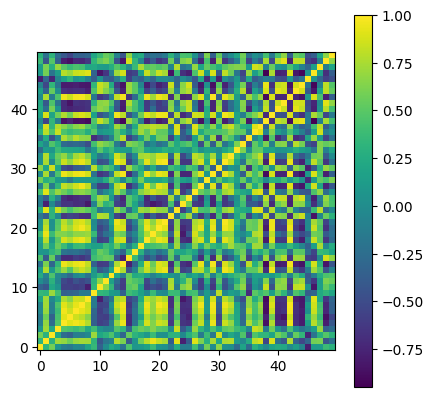

maxNumClusters25
clstrs length:2
best clustr:2
If 2 or less clusters have a quality rating less than the average then stop.
redoCluster <=1:[0] clstrs len:2


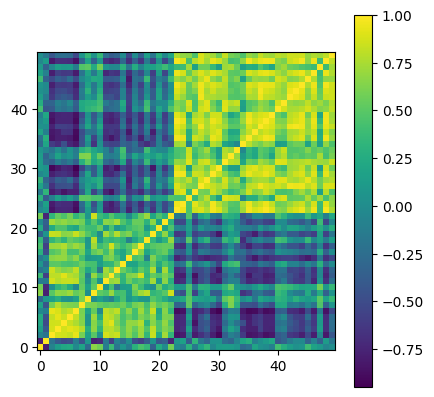

In [55]:
#Draw ground truth
matplotlib.pyplot.matshow(corr) #invert y-axis to get origo at lower left corner
matplotlib.pyplot.gca().xaxis.tick_bottom()
matplotlib.pyplot.gca().invert_yaxis()
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

#draw prediction based on ONC
corrNew, clstrsNew, silhNew = clusterKMeansTop(corr)
matplotlib.pyplot.matshow(corrNew)
matplotlib.pyplot.gca().xaxis.tick_bottom()
matplotlib.pyplot.gca().invert_yaxis()
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [56]:
for cluster_number, cluster_indices in clstrsNew.items():
    print(f"Cluster {cluster_number}:")
    for idx in cluster_indices:
        trial_number = top_trials[idx].number
        trial_params = top_trials[idx].params
        print(f"- Trial {trial_number}: {trial_params}")

Cluster 0:
- Trial 19: {'volume_adi': 0, 'volume_obv': 1, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 0, 'volatility_bbw': 1, 'volatility_bbp': 0, 'volatility_bbhi': 1, 'volatility_bbli': 0, 'volatility_kcw': 0, 'volatility_kchi': 0, 'volatility_kcli': 1, 'volatility_ui': 0, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 0, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down': 1, 'trend_psar_up_indicator': 1, 'trend_psar_down_indicator': 1, 'momentum_pvo': 0, 'momentum_pvo_hist': 0, 'others_dr': 1, 'others_cr': 1}
- Trial 8: {'volume_adi': 0, 'volume_obv': 0, 'volume_fi': 1, 'volume_em': 0, 'volume_sma_em': 0, 'volume_mfi': 1, 'volatility_bbw': 0, 'volatility_bbp': 1, 'volatility_bbhi': 1, 'volatility_bbli': 1, 'volatility_kcw': 0, 'volatility_kchi': 1, 'volatility_kcli': 0, 'volatility_ui': 1, 'trend_macd': 1, 'trend_mass_index': 0, 'trend_adx': 1, 'trend_aroon_up': 1, 'trend_aroon_down': 0, 'trend_psar_up': 0, 'trend_psar_down'

In [57]:
import pandas as pd

cluster_frequencies = []

for cluster_number, cluster_indices in clstrsNew.items():
    cluster_frequency = {}

    for idx in cluster_indices:
        trial_features = top_trials[idx].number
        trial_params = top_trials[idx].params
        for key, value in trial_params.items():
            if value == 1:
                cluster_frequency[key] = cluster_frequency.get(key, 0) + 1

    sorted_frequency = sorted(cluster_frequency.items(), key=lambda x: x[1],  reverse=True)

    print(f"Cluster {cluster_number}:")
    top_features = sorted_frequency[:10]
    df = pd.DataFrame(top_features, columns=['Feature', 'Frequency'])
    print(df)


Cluster 0:
                   Feature  Frequency
0                volume_fi         15
1               trend_macd         15
2  trend_psar_up_indicator         15
3          volatility_bbli         15
4                others_cr         14
5          volatility_bbhi         12
6          trend_psar_down         12
7           volatility_bbp         12
8           volatility_kcw         12
9               volume_adi         12
Cluster 1:
            Feature  Frequency
0   volatility_kcli         19
1      momentum_pvo         17
2         others_dr         17
3   volatility_kchi         16
4         trend_adx         16
5  trend_mass_index         16
6         volume_em         15
7     volume_sma_em         15
8    trend_aroon_up         15
9        trend_macd         15


In [58]:
cluster_lists = []

# Iterate through each cluster and its members
for cluster_number, cluster_indices in clstrsNew.items():
    cluster_list = []

    # Iterate through each index in the cluster
    for idx in cluster_indices:
        trial_number = top_trials[idx].number
        cluster_list.append(trial_number)

    cluster_lists.append(cluster_list)

# Print the lists for each cluster
for i, cluster_list in enumerate(cluster_lists):
    print(f"Cluster {i}: {cluster_list}")

Cluster 0: [19, 8, 41, 33, 44, 32, 30, 5, 9, 3, 35, 15, 16, 37, 21, 17, 0, 26, 47, 12, 18, 24, 34]
Cluster 1: [10, 6, 1, 31, 43, 22, 49, 25, 14, 2, 28, 36, 23, 29, 27, 46, 20, 39, 42, 7, 11, 4, 45, 40, 13, 38, 48]


In [59]:
top_10_features_per_cluster = []

for cluster_number, cluster_indices in clstrsNew.items():
    cluster_frequency = {}

    for idx in cluster_indices:
        trial_params = top_trials[idx].params
        for key, value in trial_params.items():
            if value == 1:
                cluster_frequency[key] = cluster_frequency.get(key, 0) + 1

    sorted_cluster_frequency = sorted(cluster_frequency.items(), key=lambda x: x[1], reverse=True)
    top_10_features_cluster = [feature for feature, _ in sorted_cluster_frequency[:10]]
    top_10_features_per_cluster.append(top_10_features_cluster)
    print(f"Top 10 features for Cluster {cluster_number}: {top_10_features_cluster}")

Top 10 features for Cluster 0: ['volume_fi', 'trend_macd', 'trend_psar_up_indicator', 'volatility_bbli', 'others_cr', 'volatility_bbhi', 'trend_psar_down', 'volatility_bbp', 'volatility_kcw', 'volume_adi']
Top 10 features for Cluster 1: ['volatility_kcli', 'momentum_pvo', 'others_dr', 'volatility_kchi', 'trend_adx', 'trend_mass_index', 'volume_em', 'volume_sma_em', 'trend_aroon_up', 'trend_macd']


In [60]:
top_10_features_per_cluster

[['volume_fi',
  'trend_macd',
  'trend_psar_up_indicator',
  'volatility_bbli',
  'others_cr',
  'volatility_bbhi',
  'trend_psar_down',
  'volatility_bbp',
  'volatility_kcw',
  'volume_adi'],
 ['volatility_kcli',
  'momentum_pvo',
  'others_dr',
  'volatility_kchi',
  'trend_adx',
  'trend_mass_index',
  'volume_em',
  'volume_sma_em',
  'trend_aroon_up',
  'trend_macd']]

In [61]:
top10_feat = pd.DataFrame(top_10_features_per_cluster)

In [62]:
selected_columns_cluster = []
for item in top_10_features_per_cluster:
  selected_columns = new_df_no_close_col.loc[:, item]
  selected_columns_cluster.append(selected_columns)

# Model selection

## Custom Early Stopping

In [63]:
from xgboost import callback

In [64]:
min_delta = 0.0001
patience = 30


class CustomEarlyStopping(callback.TrainingCallback):
    def __init__(self, min_delta, patience, verbose=False):
        super().__init__()
        self.min_delta = min_delta
        self.patience = patience
        self.verbose = verbose
        self.best_score = np.inf
        self.wait = 0
        self.stopped_epoch = 0

    def after_iteration(self, model, epoch, evals_log):
        if not evals_log:
            return False
        metric_name = next(iter(evals_log['validation_0']))
        score = evals_log['validation_0'][metric_name][-1]
        if score < (self.best_score - self.min_delta):
            self.best_score = score
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                if self.verbose:
                    print(f"\nStopping. Best score: {self.best_score}")
                self.stopped_epoch = epoch
                return True
        return False

    def get_best_score(self):
        return self.best_score

## Hyperparameter Tuning

In [65]:
def objective_params(trial, X_train, X_valid, y_train, y_valid, y_close):
    # Define the hyperparameter search space
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': 8000,  # does not matter, think of it as max epochs, and we stop the model based on early stopping, so any extremely high number works
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # can't comment, never played with that
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # you dont want to sample less than 50% of your data
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),  # you dont want to sample less than 30% of your features pr boosting round
        }
    trade_threshold  = 0.0005

    # Check duplication and skip if it's detected.
    for t in trial.study.trials:
        if t.state != optuna.trial.TrialState.COMPLETE:
            continue

    custom_early_stopping_instance = CustomEarlyStopping(min_delta=min_delta, patience=patience, verbose=True)

    # Train the model
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, callbacks=[custom_early_stopping_instance])

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)


    pos, pnl, daily_pnl, sharpe_is = sharpe_for_vn30f(y_pred_train, y_close[:len(y_pred_train)], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)
    _, _, _, sharpe_oos = sharpe_for_vn30f(y_pred_valid, y_close[len(y_pred_train):], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)

    return sharpe_oos, abs((abs(sharpe_is / sharpe_oos))-1)

In [66]:
best_params_list = []
for idx, data_item in enumerate(selected_columns_cluster):
    train_cols, _ = split_data(data_item)
    optuna_data = scale_data(train_cols)

    X_train, X_valid, y_train, y_valid = train_test_split(optuna_data,
                                                            train_data['Return'],
                                                            test_size=0.5,
                                                            shuffle=False)
    study = optuna.create_study(directions=['maximize', 'minimize'])

    unique_trials = 10
    while unique_trials > len(set(str(t.params) for t in study.trials)):
        study.optimize(lambda trial: objective_params(trial, X_train, X_valid, y_train, y_valid, train_data['Close']), n_trials=1)

    # Retrieve all trials
    trials = study.trials

    # Sort trials based on objective values
    trials.sort(key=lambda trial: trial.values, reverse=True)

    # Select top 1 trials
    params = trials[0].params
    best_params_list.append(params)

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)

    model.save_model(f'best_in_cluster_{idx}.json')

[I 2024-06-11 03:00:32,705] A new study created in memory with name: no-name-4edbce0d-0ad8-412a-a0c3-b14b05298f0f


A new study created in memory with name: no-name-4edbce0d-0ad8-412a-a0c3-b14b05298f0f
A new study created in memory with name: no-name-4edbce0d-0ad8-412a-a0c3-b14b05298f0f


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:00:39,332] Trial 0 finished with values: [-0.5229914873879623, 5.491584186702173] and parameters: {'max_depth': 5, 'learning_rate': 0.014821502523821455, 'min_child_weight': 1, 'subsample': 0.521819386945474, 'colsample_bytree': 0.7912826973691697}. 


Trial 0 finished with values: [-0.5229914873879623, 5.491584186702173] and parameters: {'max_depth': 5, 'learning_rate': 0.014821502523821455, 'min_child_weight': 1, 'subsample': 0.521819386945474, 'colsample_bytree': 0.7912826973691697}. 
Trial 0 finished with values: [-0.5229914873879623, 5.491584186702173] and parameters: {'max_depth': 5, 'learning_rate': 0.014821502523821455, 'min_child_weight': 1, 'subsample': 0.521819386945474, 'colsample_bytree': 0.7912826973691697}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:00:42,330] Trial 1 finished with values: [-0.6302169926101298, 2.5246607560015195] and parameters: {'max_depth': 3, 'learning_rate': 0.03122902767195225, 'min_child_weight': 2, 'subsample': 0.8393713951636812, 'colsample_bytree': 0.5531371087462144}. 


Trial 1 finished with values: [-0.6302169926101298, 2.5246607560015195] and parameters: {'max_depth': 3, 'learning_rate': 0.03122902767195225, 'min_child_weight': 2, 'subsample': 0.8393713951636812, 'colsample_bytree': 0.5531371087462144}. 
Trial 1 finished with values: [-0.6302169926101298, 2.5246607560015195] and parameters: {'max_depth': 3, 'learning_rate': 0.03122902767195225, 'min_child_weight': 2, 'subsample': 0.8393713951636812, 'colsample_bytree': 0.5531371087462144}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:00:45,734] Trial 2 finished with values: [-0.011824946305720311, 253.4080911668171] and parameters: {'max_depth': 3, 'learning_rate': 0.049179531365259974, 'min_child_weight': 7, 'subsample': 0.696245417376478, 'colsample_bytree': 0.6104898403069232}. 


Trial 2 finished with values: [-0.011824946305720311, 253.4080911668171] and parameters: {'max_depth': 3, 'learning_rate': 0.049179531365259974, 'min_child_weight': 7, 'subsample': 0.696245417376478, 'colsample_bytree': 0.6104898403069232}. 
Trial 2 finished with values: [-0.011824946305720311, 253.4080911668171] and parameters: {'max_depth': 3, 'learning_rate': 0.049179531365259974, 'min_child_weight': 7, 'subsample': 0.696245417376478, 'colsample_bytree': 0.6104898403069232}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:00:50,993] Trial 3 finished with values: [1.0091847704505552, 1.2976013708341734] and parameters: {'max_depth': 4, 'learning_rate': 0.022558011538883115, 'min_child_weight': 5, 'subsample': 0.8824431053214844, 'colsample_bytree': 0.627171756355265}. 


Trial 3 finished with values: [1.0091847704505552, 1.2976013708341734] and parameters: {'max_depth': 4, 'learning_rate': 0.022558011538883115, 'min_child_weight': 5, 'subsample': 0.8824431053214844, 'colsample_bytree': 0.627171756355265}. 
Trial 3 finished with values: [1.0091847704505552, 1.2976013708341734] and parameters: {'max_depth': 4, 'learning_rate': 0.022558011538883115, 'min_child_weight': 5, 'subsample': 0.8824431053214844, 'colsample_bytree': 0.627171756355265}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:00:54,013] Trial 4 finished with values: [-0.5161682665733188, 4.259434374459199] and parameters: {'max_depth': 5, 'learning_rate': 0.04075689255953584, 'min_child_weight': 10, 'subsample': 0.7763860659715847, 'colsample_bytree': 0.5701400484325274}. 


Trial 4 finished with values: [-0.5161682665733188, 4.259434374459199] and parameters: {'max_depth': 5, 'learning_rate': 0.04075689255953584, 'min_child_weight': 10, 'subsample': 0.7763860659715847, 'colsample_bytree': 0.5701400484325274}. 
Trial 4 finished with values: [-0.5161682665733188, 4.259434374459199] and parameters: {'max_depth': 5, 'learning_rate': 0.04075689255953584, 'min_child_weight': 10, 'subsample': 0.7763860659715847, 'colsample_bytree': 0.5701400484325274}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:00:57,548] Trial 5 finished with values: [-0.008645178781746189, 433.6957319757133] and parameters: {'max_depth': 4, 'learning_rate': 0.07617703905429143, 'min_child_weight': 5, 'subsample': 0.5489822626093497, 'colsample_bytree': 0.6271234625484751}. 


Trial 5 finished with values: [-0.008645178781746189, 433.6957319757133] and parameters: {'max_depth': 4, 'learning_rate': 0.07617703905429143, 'min_child_weight': 5, 'subsample': 0.5489822626093497, 'colsample_bytree': 0.6271234625484751}. 
Trial 5 finished with values: [-0.008645178781746189, 433.6957319757133] and parameters: {'max_depth': 4, 'learning_rate': 0.07617703905429143, 'min_child_weight': 5, 'subsample': 0.5489822626093497, 'colsample_bytree': 0.6271234625484751}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:01:02,284] Trial 6 finished with values: [-1.292928322957091, 0.6571420581927518] and parameters: {'max_depth': 5, 'learning_rate': 0.054120645399242634, 'min_child_weight': 8, 'subsample': 0.9238126553238272, 'colsample_bytree': 0.49072402548390626}. 


Trial 6 finished with values: [-1.292928322957091, 0.6571420581927518] and parameters: {'max_depth': 5, 'learning_rate': 0.054120645399242634, 'min_child_weight': 8, 'subsample': 0.9238126553238272, 'colsample_bytree': 0.49072402548390626}. 
Trial 6 finished with values: [-1.292928322957091, 0.6571420581927518] and parameters: {'max_depth': 5, 'learning_rate': 0.054120645399242634, 'min_child_weight': 8, 'subsample': 0.9238126553238272, 'colsample_bytree': 0.49072402548390626}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:01:05,326] Trial 7 finished with values: [0.32411328962256103, 6.800344154124028] and parameters: {'max_depth': 6, 'learning_rate': 0.039147084019823655, 'min_child_weight': 6, 'subsample': 0.8965421648046056, 'colsample_bytree': 0.882659391423561}. 


Trial 7 finished with values: [0.32411328962256103, 6.800344154124028] and parameters: {'max_depth': 6, 'learning_rate': 0.039147084019823655, 'min_child_weight': 6, 'subsample': 0.8965421648046056, 'colsample_bytree': 0.882659391423561}. 
Trial 7 finished with values: [0.32411328962256103, 6.800344154124028] and parameters: {'max_depth': 6, 'learning_rate': 0.039147084019823655, 'min_child_weight': 6, 'subsample': 0.8965421648046056, 'colsample_bytree': 0.882659391423561}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:01:08,257] Trial 8 finished with values: [0.2004914339013448, 11.225711324073231] and parameters: {'max_depth': 6, 'learning_rate': 0.08647448697105946, 'min_child_weight': 4, 'subsample': 0.9285122747990033, 'colsample_bytree': 0.9172838042010949}. 


Trial 8 finished with values: [0.2004914339013448, 11.225711324073231] and parameters: {'max_depth': 6, 'learning_rate': 0.08647448697105946, 'min_child_weight': 4, 'subsample': 0.9285122747990033, 'colsample_bytree': 0.9172838042010949}. 
Trial 8 finished with values: [0.2004914339013448, 11.225711324073231] and parameters: {'max_depth': 6, 'learning_rate': 0.08647448697105946, 'min_child_weight': 4, 'subsample': 0.9285122747990033, 'colsample_bytree': 0.9172838042010949}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:01:11,537] Trial 9 finished with values: [0.4198919771012255, 6.511624348717649] and parameters: {'max_depth': 4, 'learning_rate': 0.059959296238169646, 'min_child_weight': 2, 'subsample': 0.7409785357838287, 'colsample_bytree': 0.9038426294476078}. 


Trial 9 finished with values: [0.4198919771012255, 6.511624348717649] and parameters: {'max_depth': 4, 'learning_rate': 0.059959296238169646, 'min_child_weight': 2, 'subsample': 0.7409785357838287, 'colsample_bytree': 0.9038426294476078}. 
Trial 9 finished with values: [0.4198919771012255, 6.511624348717649] and parameters: {'max_depth': 4, 'learning_rate': 0.059959296238169646, 'min_child_weight': 2, 'subsample': 0.7409785357838287, 'colsample_bytree': 0.9038426294476078}. 


[I 2024-06-11 03:01:11,646] A new study created in memory with name: no-name-10b2de3c-21db-4116-b178-787889724de3


A new study created in memory with name: no-name-10b2de3c-21db-4116-b178-787889724de3
A new study created in memory with name: no-name-10b2de3c-21db-4116-b178-787889724de3


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:01:18,574] Trial 0 finished with values: [-0.5792303476912809, 4.9470823338940235] and parameters: {'max_depth': 4, 'learning_rate': 0.013980899937893882, 'min_child_weight': 5, 'subsample': 0.5284886638213824, 'colsample_bytree': 0.6618246985338987}. 


Trial 0 finished with values: [-0.5792303476912809, 4.9470823338940235] and parameters: {'max_depth': 4, 'learning_rate': 0.013980899937893882, 'min_child_weight': 5, 'subsample': 0.5284886638213824, 'colsample_bytree': 0.6618246985338987}. 
Trial 0 finished with values: [-0.5792303476912809, 4.9470823338940235] and parameters: {'max_depth': 4, 'learning_rate': 0.013980899937893882, 'min_child_weight': 5, 'subsample': 0.5284886638213824, 'colsample_bytree': 0.6618246985338987}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:01:21,877] Trial 1 finished with values: [-0.22497234487102025, 9.573253391873909] and parameters: {'max_depth': 4, 'learning_rate': 0.032379500401630464, 'min_child_weight': 9, 'subsample': 0.7187800527566156, 'colsample_bytree': 0.3475069849325883}. 


Trial 1 finished with values: [-0.22497234487102025, 9.573253391873909] and parameters: {'max_depth': 4, 'learning_rate': 0.032379500401630464, 'min_child_weight': 9, 'subsample': 0.7187800527566156, 'colsample_bytree': 0.3475069849325883}. 
Trial 1 finished with values: [-0.22497234487102025, 9.573253391873909] and parameters: {'max_depth': 4, 'learning_rate': 0.032379500401630464, 'min_child_weight': 9, 'subsample': 0.7187800527566156, 'colsample_bytree': 0.3475069849325883}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:01:25,945] Trial 2 finished with values: [-0.24148028304388244, 11.474539721650725] and parameters: {'max_depth': 3, 'learning_rate': 0.03724788579388508, 'min_child_weight': 5, 'subsample': 0.7750185211648108, 'colsample_bytree': 0.9291193049717608}. 


Trial 2 finished with values: [-0.24148028304388244, 11.474539721650725] and parameters: {'max_depth': 3, 'learning_rate': 0.03724788579388508, 'min_child_weight': 5, 'subsample': 0.7750185211648108, 'colsample_bytree': 0.9291193049717608}. 
Trial 2 finished with values: [-0.24148028304388244, 11.474539721650725] and parameters: {'max_depth': 3, 'learning_rate': 0.03724788579388508, 'min_child_weight': 5, 'subsample': 0.7750185211648108, 'colsample_bytree': 0.9291193049717608}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:01:31,273] Trial 3 finished with values: [-0.29849366655438736, 11.294287361234053] and parameters: {'max_depth': 5, 'learning_rate': 0.0561628093181762, 'min_child_weight': 3, 'subsample': 0.6747814489293057, 'colsample_bytree': 0.7767411226484995}. 


Trial 3 finished with values: [-0.29849366655438736, 11.294287361234053] and parameters: {'max_depth': 5, 'learning_rate': 0.0561628093181762, 'min_child_weight': 3, 'subsample': 0.6747814489293057, 'colsample_bytree': 0.7767411226484995}. 
Trial 3 finished with values: [-0.29849366655438736, 11.294287361234053] and parameters: {'max_depth': 5, 'learning_rate': 0.0561628093181762, 'min_child_weight': 3, 'subsample': 0.6747814489293057, 'colsample_bytree': 0.7767411226484995}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:01:37,619] Trial 4 finished with values: [-0.7394092479324357, 2.5913835431288685] and parameters: {'max_depth': 3, 'learning_rate': 0.017724649405663817, 'min_child_weight': 8, 'subsample': 0.6878218417983368, 'colsample_bytree': 0.40820919302486347}. 


Trial 4 finished with values: [-0.7394092479324357, 2.5913835431288685] and parameters: {'max_depth': 3, 'learning_rate': 0.017724649405663817, 'min_child_weight': 8, 'subsample': 0.6878218417983368, 'colsample_bytree': 0.40820919302486347}. 
Trial 4 finished with values: [-0.7394092479324357, 2.5913835431288685] and parameters: {'max_depth': 3, 'learning_rate': 0.017724649405663817, 'min_child_weight': 8, 'subsample': 0.6878218417983368, 'colsample_bytree': 0.40820919302486347}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:01:43,123] Trial 5 finished with values: [-0.8759711686034124, 1.4239512799098382] and parameters: {'max_depth': 3, 'learning_rate': 0.08214806208862832, 'min_child_weight': 10, 'subsample': 0.877017373927574, 'colsample_bytree': 0.5348092145458346}. 


Trial 5 finished with values: [-0.8759711686034124, 1.4239512799098382] and parameters: {'max_depth': 3, 'learning_rate': 0.08214806208862832, 'min_child_weight': 10, 'subsample': 0.877017373927574, 'colsample_bytree': 0.5348092145458346}. 
Trial 5 finished with values: [-0.8759711686034124, 1.4239512799098382] and parameters: {'max_depth': 3, 'learning_rate': 0.08214806208862832, 'min_child_weight': 10, 'subsample': 0.877017373927574, 'colsample_bytree': 0.5348092145458346}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:01:47,391] Trial 6 finished with values: [0.6832303810427155, 3.689020264644806] and parameters: {'max_depth': 6, 'learning_rate': 0.04469908936792014, 'min_child_weight': 2, 'subsample': 0.8020322587120092, 'colsample_bytree': 0.795082819238474}. 


Trial 6 finished with values: [0.6832303810427155, 3.689020264644806] and parameters: {'max_depth': 6, 'learning_rate': 0.04469908936792014, 'min_child_weight': 2, 'subsample': 0.8020322587120092, 'colsample_bytree': 0.795082819238474}. 
Trial 6 finished with values: [0.6832303810427155, 3.689020264644806] and parameters: {'max_depth': 6, 'learning_rate': 0.04469908936792014, 'min_child_weight': 2, 'subsample': 0.8020322587120092, 'colsample_bytree': 0.795082819238474}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:01:51,765] Trial 7 finished with values: [-0.5138316358648887, 4.888550431986647] and parameters: {'max_depth': 6, 'learning_rate': 0.01086643668198597, 'min_child_weight': 9, 'subsample': 0.6665800589120934, 'colsample_bytree': 0.49269482468792875}. 


Trial 7 finished with values: [-0.5138316358648887, 4.888550431986647] and parameters: {'max_depth': 6, 'learning_rate': 0.01086643668198597, 'min_child_weight': 9, 'subsample': 0.6665800589120934, 'colsample_bytree': 0.49269482468792875}. 
Trial 7 finished with values: [-0.5138316358648887, 4.888550431986647] and parameters: {'max_depth': 6, 'learning_rate': 0.01086643668198597, 'min_child_weight': 9, 'subsample': 0.6665800589120934, 'colsample_bytree': 0.49269482468792875}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:01:57,092] Trial 8 finished with values: [-0.1630705530637403, 19.320679049277604] and parameters: {'max_depth': 3, 'learning_rate': 0.06894460209280583, 'min_child_weight': 6, 'subsample': 0.6737811078087845, 'colsample_bytree': 0.8082195514981381}. 


Trial 8 finished with values: [-0.1630705530637403, 19.320679049277604] and parameters: {'max_depth': 3, 'learning_rate': 0.06894460209280583, 'min_child_weight': 6, 'subsample': 0.6737811078087845, 'colsample_bytree': 0.8082195514981381}. 
Trial 8 finished with values: [-0.1630705530637403, 19.320679049277604] and parameters: {'max_depth': 3, 'learning_rate': 0.06894460209280583, 'min_child_weight': 6, 'subsample': 0.6737811078087845, 'colsample_bytree': 0.8082195514981381}. 


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-06-11 03:02:00,822] Trial 9 finished with values: [-0.19725792410931126, 15.41369827627926] and parameters: {'max_depth': 5, 'learning_rate': 0.025982588745369295, 'min_child_weight': 9, 'subsample': 0.6041285181031717, 'colsample_bytree': 0.4671372861083635}. 


Trial 9 finished with values: [-0.19725792410931126, 15.41369827627926] and parameters: {'max_depth': 5, 'learning_rate': 0.025982588745369295, 'min_child_weight': 9, 'subsample': 0.6041285181031717, 'colsample_bytree': 0.4671372861083635}. 
Trial 9 finished with values: [-0.19725792410931126, 15.41369827627926] and parameters: {'max_depth': 5, 'learning_rate': 0.025982588745369295, 'min_child_weight': 9, 'subsample': 0.6041285181031717, 'colsample_bytree': 0.4671372861083635}. 


In [67]:
# trials = study.trials
# trials.sort(key=lambda trial: trial.values, reverse=True)
# study.trials_dataframe().sort_values('values_0', ascending=False)

Test on hold_out

In [68]:
train_data, hold_out = split_data(data)

In [69]:
sharpe_list = []
trade_threshold  = 0.0005

for idx, data_item in enumerate(selected_columns_cluster):

    _, hold_out_cols = split_data(data_item)

    xbg_reg = xgb.XGBRegressor()
    # Create and train model
    xbg_reg.load_model(f"best_in_cluster_{idx}.json")

    # Make predictions
    y_hold_out = xbg_reg.predict(hold_out_cols)
    pos, pnl, daily, sharpe = sharpe_for_vn30f(y_hold_out, hold_out['Return'], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)

    sharpe_list.append(sharpe)

sharpe_list

[0.0, 0.16521071798753945]

In [70]:
def return_result_df(hold_out, y_hold_out, data, train_data, pos, pnl):
    result = pd.DataFrame()
    result['Close_Holdout'] = hold_out['Close']
    result['Ground_value_Holdout'] = hold_out['Return']
    result['Predict_diff_Holdout'] = pd.Series(y_hold_out, index=data.index[len(train_data):len(data)])
    result['Position_predict_Holdout'] = pd.Series(pos, index=data.index[len(train_data):len(data)])
    result['PNL_Holdout'] = pd.Series(pnl)
    return result

Pnl ratio for cluster 0: 16042    NaN
16043    NaN
16044    NaN
16045    NaN
16046    NaN
        ... 
24057    0.0
24058    0.0
24059    0.0
24060    0.0
24061    0.0
Length: 8020, dtype: float64
Pnl ratio for cluster 1: 16042         NaN
16043         NaN
16044         NaN
16045         NaN
16046         NaN
           ...   
24057    0.012928
24058    0.012928
24059    0.012928
24060    0.012928
24061    0.012928
Length: 8020, dtype: float64


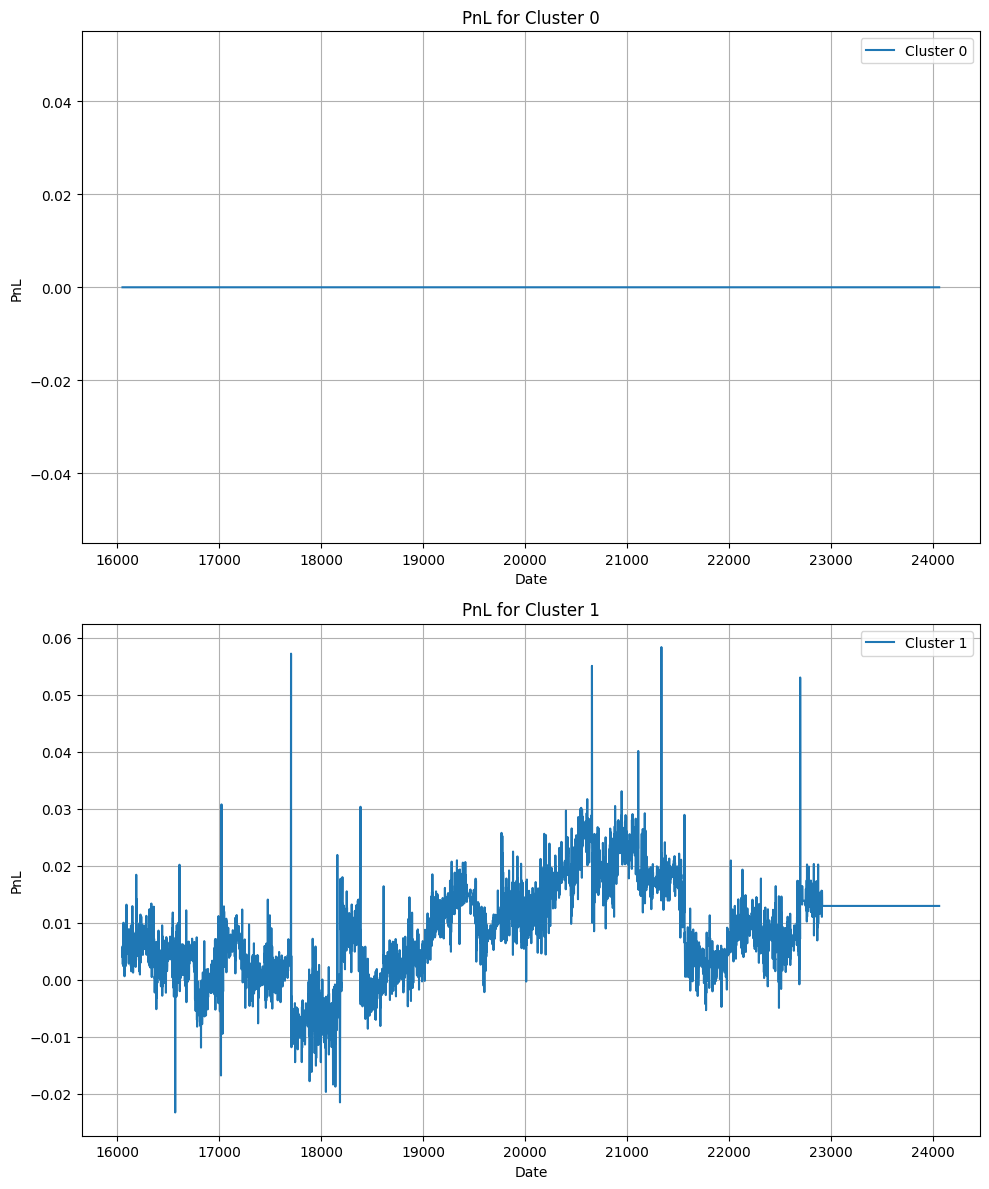

In [71]:
pnl_data = []
sharpe_list = []
result = None
trade_threshold  = 0.0005

# Create a single figure and set of subplots
fig, axes = plt.subplots(len(selected_columns_cluster), figsize=(10, 12))

for idx, data_item in enumerate(selected_columns_cluster):
    _, hold_out_cols = split_data(data_item)

    # Create and train model
    model.load_model(f"best_in_cluster_{idx}.json")

    # Make predictions
    y_hold_out = model.predict(hold_out_cols)
    pos, pnl, daily, sharpe = sharpe_for_vn30f(y_hold_out, hold_out['Return'], trade_threshold=trade_threshold, fee_perc=0.01, periods=10)

    print(f"Pnl ratio for cluster {idx}: {pnl}")
    # Append PnL data to the list
    pnl_data.append(pnl)
    result = return_result_df(hold_out, y_hold_out, data, train_data, pos, pnl)
    sharpe_list.append(sharpe)

    # Plot PnL for each cluster
    if len(selected_columns_cluster) == 1:
        ax = axes
    else:
        ax = axes[idx]

    ax.plot(pnl, label=f'Cluster {idx}')
    ax.set_title(f'PnL for Cluster {idx}')
    ax.set_xlabel('Date')
    ax.set_ylabel('PnL')
    ax.legend()
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [72]:
#Top 10 feature into list
feature=[]
for i in top_10_features_per_cluster:
    listToStr = ' '.join([str(elem) for elem in i])
    feature.append(listToStr)
print(feature)

['volume_fi trend_macd trend_psar_up_indicator volatility_bbli others_cr volatility_bbhi trend_psar_down volatility_bbp volatility_kcw volume_adi', 'volatility_kcli momentum_pvo others_dr volatility_kchi trend_adx trend_mass_index volume_em volume_sma_em trend_aroon_up trend_macd']


In [73]:
name=[]
for i in range(len(selected_columns_cluster)):
  name.append( 'Cluster '+ str(i))

In [74]:
dict = {'Top 10 Feature' : feature, 'Best params': best_params_list, 'Best sharpe':sharpe_list}
df_result = pd.DataFrame(dict, index=name)
df_result

,Top 10 Feature,Best params,Best sharpe
Cluster 0,volume_fi trend_macd trend_psar_up_indicator v...,"{'max_depth': 4, 'learning_rate': 0.0225580115...",0.000000
Cluster 1,volatility_kcli momentum_pvo others_dr volatil...,"{'max_depth': 6, 'learning_rate': 0.0446990893...",0.165211


In [75]:
#DataFrame of Pnl hold out
df_pnl = pd.DataFrame()
for i in range(len(selected_columns_cluster)):
  df_pnl[name[i]]=pnl_data[i]
df_pnl

,Cluster 0,Cluster 1
16042,NaN,NaN
16043,NaN,NaN
16044,NaN,NaN
16045,NaN,NaN
16046,NaN,NaN
...,...,...
24057,0.0,0.012928
24058,0.0,0.012928
24059,0.0,0.012928
24060,0.0,0.012928
